# Assignment 2: Large Language Models for Text Classification

### CS 410/510 Large Language Models Fall 2024

#### Greg Witt

## Load Dataset

**Install Dependencies**

In [ ]:
!pip install datasets

**Split DataSets**

In [1]:
from datasets import load_dataset
import random

# load the training set of tweets
ds_train = load_dataset("cardiffnlp/tweet_sentiment_multilingual", "english", split="train")
# the dataset labels {0 : negative, 1: neutral, 2: positive }
print(f"""tweet_sentiment_multilingual training dataset: 
    -----------------------------------------
        {ds_train} 
    """)
random_tweet_index = random.randint(0,1839)
print(f"""
    Random Tweet:
    {ds_train['text'][random_tweet_index]}

    Label: 
    {ds_train['label'][random_tweet_index] }
""")


tweet_sentiment_multilingual training dataset: 
    -----------------------------------------
        Dataset({
    features: ['text', 'label'],
    num_rows: 1839
}) 
    

    Random Tweet:
    Friends and Seinfeld (I didn't get cable until 3rd grade so I watched the shows on satellite) 

    Label: 
    1



In [2]:

# load the training set of tweets
ds_validation = load_dataset("cardiffnlp/tweet_sentiment_multilingual", "english", split="validation")
# the dataset labels {0 : negative, 1: neutral, 2: positive }
print(f"""tweet_sentiment_multilingual validation set: 
    -----------------------------------------
        {ds_validation}
    """)
random_tweet_index = random.randint(0,324)
print(f"""
    Random Tweet:
    {ds_validation['text'][random_tweet_index]}

    Label: 
    {ds_validation['label'][random_tweet_index] }
""")


tweet_sentiment_multilingual validation set: 
    -----------------------------------------
        Dataset({
    features: ['text', 'label'],
    num_rows: 324
})
    

    Random Tweet:
    I can\u2019t believe the 3 important people in my life are going to Hawaii Friday without me 

    Label: 
    0



**Load Model Dependencies**

In [ ]:
!pip install transformers torch

## Experiments 1: Zero-Shot Inference 

### Create Prompt Iteration Function

### Approach 1: Parse Single Token Response

This approach prompts the model in question for a sentiment classification of a tweet, the **[AutoModelForCausalLM's](https://huggingface.co/docs/transformers/v4.46.0/en/main_classes/text_generation#transformers.GenerationMixin.generate)** `mode.generate()` call is invoked in order to ellicit a response to our provided prompt. the `generate()` method can be provided with several parameters. this approach modifies the **[GenerationConfiguration](https://huggingface.co/docs/transformers/v4.46.0/en/main_classes/text_generation#transformers.GenerationConfig)** allowing for certain constraints. for this approach we ensure that the `max_new_tokens=1` and `pad_token_id` is set to ensure there is only one token generated from the model. This token is then used to represent our model's response to the sentiment prompt. 

This approach can work but there are risks associated with this method, because these models haven't gone through any **fine-tuning**. Meaning their lack of training hasn't prepared them to for **sentiment classification**, meaning instead of receiving a "0" for neutral, "1" for negative, or "2" for positive there could be other undesirable tokens coming back. To handle this I created a `santize_response()` method that will take the generated tokens and determine if the response can be related to a sentiment classification.

In [3]:
import re

def santize_response(response_token):
    if re.search(r'\d', response_token):
        return int(response_token)
    else:
        return 0


### Llama 3.2 1B: Zero Shot Inference

In [4]:

from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

llama_3_2_1B = "meta-llama/Llama-3.2-1B"

llama_3_2_1B_tokenizer = AutoTokenizer.from_pretrained(llama_3_2_1B)

llama_3_2_1B_model = AutoModelForCausalLM.from_pretrained(llama_3_2_1B)



In [7]:
prompt_template = "\"{}\" \n Sentiment (positive (2), negative (0), neutral (1)): "

In [102]:
import numpy as np

# hold the ground_truths
llama_3_2_1B_ground_truths = []
# hold the sentiment_predictions
llama_3_2_1B_sentiment_preds = []

# iterate through the validation set
for tweet, label in zip(ds_validation['text'], ds_validation['label']):
    prompt_tweet = tweet
    gt_label = label
    # combine the prompt
    prompt = prompt_template.format(prompt_tweet)
    
    # generate the response
    prompt_ids = llama_3_2_1B_tokenizer.encode(prompt, return_tensors="pt")

    outputs = llama_3_2_1B_model.generate(
                        prompt_ids,
                        temperature=0.86,
                        do_sample=True,
                        pad_token_id=llama_3_2_1B_tokenizer.eos_token_id,
                        max_new_tokens=1
                    )
    
    # get the response tokens from the model
    generated_tokens = outputs[-1]
    
    generated_response = llama_3_2_1B_tokenizer.decode(generated_tokens, skip_special_tokens=True)

    # pass the generated_response to a sanitizer that determines if the response is valid
    sentiment_resp = santize_response(generated_response[-1])
    
    # Responses being compared to the Ground_Truth Labels
    # print(f"Generated Response: {sentiment_resp}")
    # print(f"Ground Truth: {gt_label}")

    llama_3_2_1B_ground_truths.append(gt_label)
    llama_3_2_1B_sentiment_preds.append(sentiment_resp)

llama_3_2_1B_ground_truths = np.asarray(llama_3_2_1B_ground_truths)
llama_3_2_1B_sentiment_preds = np.asarray(llama_3_2_1B_sentiment_preds)

### Build Classification Report 

**Import Python Libraries**

In [152]:
pip install scikit-learn matplotlib seaborn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [103]:
from sklearn.metrics import classification_report

zero_shot_llama_3_2_1B_model_results = classification_report(llama_3_2_1B_ground_truths, 
                                                             llama_3_2_1B_sentiment_preds, 
                                                             output_dict=True)

print(classification_report(llama_3_2_1B_ground_truths, llama_3_2_1B_sentiment_preds))

              precision    recall  f1-score   support

           0       0.31      0.50      0.38       108
           1       0.34      0.25      0.29       108
           2       0.39      0.26      0.31       108

    accuracy                           0.34       324
   macro avg       0.35      0.34      0.33       324
weighted avg       0.35      0.34      0.33       324



### Build Confusion Matrix

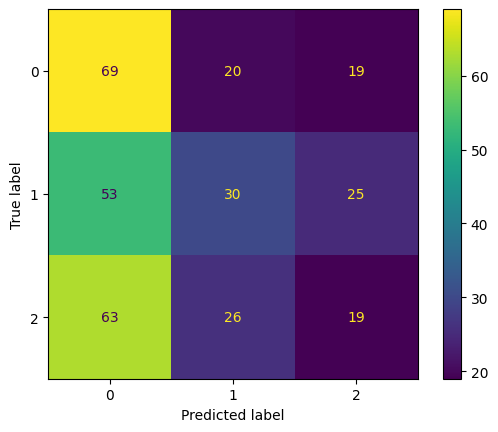

In [93]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(llama_3_2_1B_ground_truths, llama_3_2_1B_sentiment_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show()

## Llama 3.2 3B: Zero Shot Inference

In [37]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

llama_3_2_3B = "meta-llama/Llama-3.2-3B"

llama_3_2_3B_tokenizer = AutoTokenizer.from_pretrained(llama_3_2_3B)

llama_3_2_3B_model = AutoModelForCausalLM.from_pretrained(llama_3_2_3B)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [12]:
prompt_template = "\"{}\" \n Sentiment (positive (2), negative (0), neutral (1)): "

In [52]:
import re

def santize_response(response_token):
    if re.search(r'\d', response_token):
       if int(response_token) > 2: 
           return 0
       else: 
           return int(response_token)
        
    else:
        return 0


In [107]:
import numpy as np

# hold the ground_truths
llama_3_2_3B_ground_truths = []
# hold the sentiment_predictions
llama_3_2_3B_sentiment_preds = []

# iterate through the validation set
for tweet, label in zip(ds_validation['text'], ds_validation['label']):
    prompt_tweet = tweet
    gt_label = label
    # combine the prompt
    prompt = prompt_template.format(prompt_tweet)
    
    # generate the response
    prompt_ids = llama_3_2_3B_tokenizer.encode(prompt, return_tensors="pt")

    outputs = llama_3_2_3B_model.generate(
                        prompt_ids,
                        do_sample=True,
                        temperature=0.65,
                        pad_token_id=llama_3_2_3B_tokenizer.eos_token_id,
                        max_new_tokens=1
                    )
    
    # get the response tokens from the model
    generated_tokens = outputs[-1]
    
    generated_response = llama_3_2_1B_tokenizer.decode(generated_tokens, skip_special_tokens=True)

    # pass the generated_response to a sanitizer that determines if the response is valid
    sentiment_resp = santize_response(generated_response[-1])
    
    # Responses being compared to the Ground_Truth Labels
    # print(f"Generated Response: {sentiment_resp}")
    # print(f"Ground Truth: {gt_label}")

    llama_3_2_3B_ground_truths.append(gt_label)
    llama_3_2_3B_sentiment_preds.append(sentiment_resp)

llama_3_2_3B_ground_truths = np.asarray(llama_3_2_3B_ground_truths)
llama_3_2_3B_sentiment_preds = np.asarray(llama_3_2_3B_sentiment_preds)


In [108]:
from sklearn.metrics import classification_report

zero_shot_llama_3_2_3B_results = classification_report(llama_3_2_3B_ground_truths, llama_3_2_3B_sentiment_preds, output_dict=True)

print(classification_report(llama_3_2_3B_ground_truths, llama_3_2_3B_sentiment_preds))

              precision    recall  f1-score   support

           0       0.33      0.60      0.42       108
           1       0.28      0.05      0.08       108
           2       0.34      0.33      0.33       108

    accuracy                           0.33       324
   macro avg       0.31      0.33      0.28       324
weighted avg       0.31      0.33      0.28       324



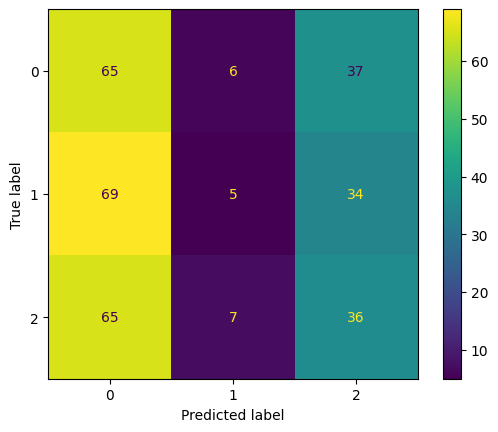

In [109]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(llama_3_2_3B_ground_truths, llama_3_2_3B_sentiment_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show()

## Phi-3.5-mini-instruct: Zero Shot Inference

#### [Phi 3.5 Instruct]()

In [56]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# model name
phi_model = "microsoft/Phi-3.5-mini-instruct"

phi_3_5_tokenizer = AutoTokenizer.from_pretrained(phi_model)

phi_3_5_model = AutoModelForCausalLM.from_pretrained(phi_model)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [28]:
prompt_template = "\"{}\" \n Sentiment (positive (2), negative (0), neutral (1)): "

In [57]:
import re

def santize_response(response_token):
    if re.search(r'\d', response_token):
       if int(response_token) > 2: 
           return 0
       else: 
           return int(response_token)
        
    else:
        return 0


In [110]:
import numpy as np

# hold the ground_truths
phi_3_5_ground_truths = []
# hold the sentiment_predictions
phi_3_5_sentiment_preds = []

# iterate through the validation set
for tweet, label in zip(ds_validation['text'], ds_validation['label']):
    prompt_tweet = tweet
    gt_label = label
    # combine the prompt
    prompt = prompt_template.format(prompt_tweet)
    
    # generate the response
    prompt_ids = phi_3_5_tokenizer.encode(prompt, return_tensors="pt")

    outputs = phi_3_5_model.generate(
                        prompt_ids,
                        temperature=0.23,
                        do_sample=True,
                        pad_token_id=phi_3_5_tokenizer.eos_token_id,
                        max_new_tokens=1
                    )
    
    # get the response tokens from the model
    generated_tokens = outputs[-1]
    
    generated_response = phi_3_5_tokenizer.decode(generated_tokens, skip_special_tokens=True)

    # pass the generated_response to a sanitizer that determines if the response is valid
    sentiment_resp = santize_response(generated_response[-1])
    
    # Responses being compared to the Ground_Truth Labels
    # print(f"Generated Response: {sentiment_resp}")
    # print(f"Ground Truth: {gt_label}")

    phi_3_5_ground_truths.append(gt_label)
    phi_3_5_sentiment_preds.append(sentiment_resp)

phi_3_5_ground_truths = np.asarray(phi_3_5_ground_truths)
phi_3_5_sentiment_preds = np.asarray(phi_3_5_sentiment_preds)


In [113]:
from sklearn.metrics import classification_report

zero_shot_phi_3_5_results = classification_report(phi_3_5_ground_truths, phi_3_5_sentiment_preds, output_dict=True)

print(classification_report(phi_3_5_ground_truths, phi_3_5_sentiment_preds))

              precision    recall  f1-score   support

           0       0.46      0.76      0.57       108
           1       0.83      0.05      0.09       108
           2       0.50      0.65      0.56       108

    accuracy                           0.48       324
   macro avg       0.60      0.48      0.41       324
weighted avg       0.60      0.48      0.41       324



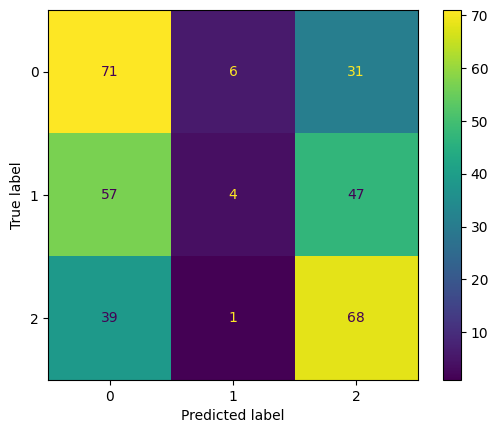

In [84]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(phi_3_5_ground_truths, phi_3_5_sentiment_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show()

## Experiment 1: Zero-Shot Results

### Zero-Shot Model Recall Scores

Text(0.5, 1.0, 'Zero Shot Model Recall Scores')

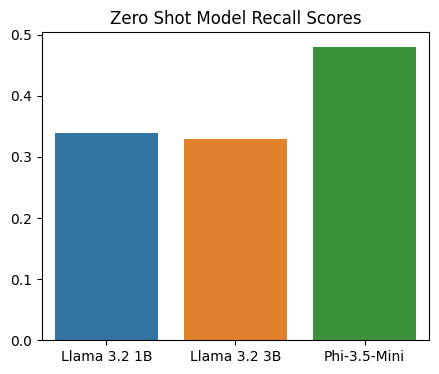

In [281]:
import numpy as np  
import matplotlib.pyplot as plt 
import seaborn as sns

sns.color_palette("Set2")
  
models = ['Llama 3.2 1B','Llama 3.2 3B','Phi-3.5-Mini'] 

llama_32_1b = round(zero_shot_llama_3_2_1B_model_results['macro avg']['recall'], 2)

llama_32_3b = round(zero_shot_llama_3_2_3B_results['macro avg']['recall'], 2)

phi_35_mini = round(zero_shot_phi_3_5_results['macro avg']['recall'], 2)

precision_scores = [llama_32_1b, llama_32_3b, phi_35_mini]

plt.figure(figsize=(5,4), dpi=100)
plt.yticks()
sns.barplot(x=models, y=precision_scores, hue=models, legend="auto", )
plt.title('Zero Shot Model Recall Scores')

### Zero-Shot Models F1-Scores

Text(0.5, 1.0, 'Zero Shot Model F-1 Scores')

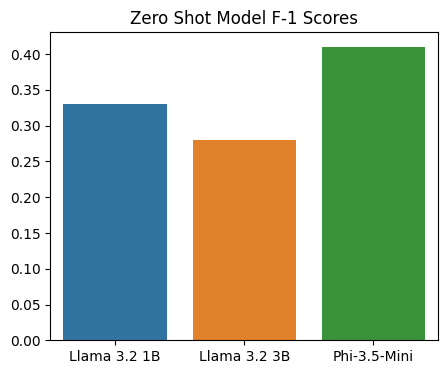

In [279]:
import numpy as np  
import matplotlib.pyplot as plt 
import seaborn as sns

sns.color_palette("Set2")
  
models = ['Llama 3.2 1B','Llama 3.2 3B','Phi-3.5-Mini'] 

llama_32_1b = round(zero_shot_llama_3_2_1B_model_results['macro avg']['f1-score'], 2)

llama_32_3b = round(zero_shot_llama_3_2_3B_results['macro avg']['f1-score'], 2)

phi_35_mini = round(zero_shot_phi_3_5_results['macro avg']['f1-score'], 2)

precision_scores = [llama_32_1b, llama_32_3b, phi_35_mini]

plt.figure(figsize=(5,4), dpi=100)
plt.yticks()
sns.barplot(x=models, y=precision_scores, hue=models, legend="auto", )
plt.title('Zero Shot Model F-1 Scores')

### Zero-Shot Model Percisions

Text(0.5, 1.0, 'Zero Shot Model Precision Scores')

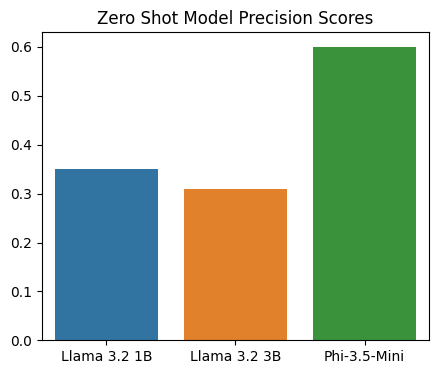

In [280]:
import numpy as np  
import matplotlib.pyplot as plt 
import seaborn as sns

sns.color_palette("Set2")
  
models = ['Llama 3.2 1B','Llama 3.2 3B','Phi-3.5-Mini'] 

llama_32_1b = round(zero_shot_llama_3_2_1B_model_results['macro avg']['precision'], 2)

llama_32_3b = round(zero_shot_llama_3_2_3B_results['macro avg']['precision'], 2)

phi_35_mini = round(zero_shot_phi_3_5_results['macro avg']['precision'], 2)

precision_scores = [llama_32_1b, llama_32_3b, phi_35_mini]

plt.figure(figsize=(5,4), dpi=100)
sns.barplot(x=models, y=precision_scores, hue=models, legend="auto", )
plt.title('Zero Shot Model Precision Scores')

## Experiment 2: Few-Shot In-Context Learning

### Llama 3.2 1B: Few-Shot In-Context Learning

**Generate a Prompt**

In [184]:
import random 

# sets a for consistent repeatability amongst the tests
random.seed(23)

# filter the data for each type of tweet. 
# filter is specific to hugging face datasets 
# it will take a lambda that will return a boolean value to filter elements on

negative_tweets = ds_train.filter(lambda x: x['label'] == 0)
neutral_tweets = ds_train.filter(lambda x: x['label'] == 1)
positive_tweets = ds_train.filter(lambda x: x['label'] == 2)

# Optional: Preview the sizes
print(f"Number of negative tweets: {len(negative_tweets)}")
print(f"Number of neutral tweets: {len(neutral_tweets)}")
print(f"Number of positive tweets: {len(positive_tweets)}")

print()
random_num = random.randint(0,613)

print(f"Random Negative Tweet: {negative_tweets['text'][random_num]}")

print(f"Random Neutral Tweet: {neutral_tweets['text'][random_num]}")

print(f"Random Positive Tweet: {positive_tweets['text'][random_num]}")


Number of negative tweets: 613
Number of neutral tweets: 613
Number of positive tweets: 613

Random Negative Tweet: "I'm sorry, but Randy Orton is the most plain wrestler on the roster. He does nothing for me in the main event spot. 2nd is Sheamus." 
Random Neutral Tweet: @user @user If it weren't for Blair there would have been no Good Friday Agreement, and the IRA would have won!" 
Random Positive Tweet: Last night may have been my last Digi concert for a while. But I had an amazing night. Thank you for everything Digi. @user 


In [187]:
def generate_few_shot_prompt(validation_tweet):
    
    # Format the few-shot prompt with placeholders
    few_shot_prompt = """
    {} 
        
    Sentiment (positive (2), negative (0), neutral (1)): {} 
        
    {} 
        
    Sentiment (positive (2), negative (0), neutral (1)): {} 
        
    {} 
        
    Sentiment (positive (2), negative (0), neutral (1)): {} 
        
    {} 
        
    Sentiment (positive (2), negative (0), neutral (1)): {} 
        
    {} 
        
    Sentiment (positive (2), negative (0), neutral (1)): {} 
        
    {} 
        
    Sentiment (positive (2), negative (0), neutral (1)): {}  
    """

    # Flatten the list of text-label pairs for easy insertion
    tweet_texts_and_labels = []

    for tweet in range(2):
        random_num = random.randint(0,612)
        tweet_texts_and_labels.extend([positive_tweets['text'][random_num], positive_tweets['label'][random_num]])
        random_num = random.randint(0,612)
        tweet_texts_and_labels.extend([negative_tweets['text'][random_num], negative_tweets['label'][random_num]])
        random_num = random.randint(0,612)
        tweet_texts_and_labels.extend([neutral_tweets['text'][random_num], neutral_tweets['label'][random_num]])


    # print(tweet_texts_and_labels)

    # Use the format method to fill in the placeholders
    filled_prompt = few_shot_prompt.format(*tweet_texts_and_labels)

    filled_prompt += f""" 
    {validation_tweet}

    Sentiment (positive (2), negative (0), netural (1)): """

    return filled_prompt

In [200]:
import numpy as np

# hold the ground_truths
llama_3_2_1B_ground_truths = []
# hold the sentiment_predictions
llama_3_2_1B_sentiment_preds = []

# iterate through the validation set
for tweet, label in zip(ds_validation['text'], ds_validation['label']):
    prompt_tweet = tweet
    gt_label = label
    # combine the prompt
    prompt = generate_few_shot_prompt(prompt_tweet)
    
    # generate the response
    prompt_ids = llama_3_2_1B_tokenizer.encode(prompt, return_tensors="pt")

    outputs = llama_3_2_1B_model.generate(
                        prompt_ids,
                        temperature=0.18,
                        do_sample=True,
                        pad_token_id=llama_3_2_1B_tokenizer.eos_token_id,
                        max_new_tokens=1
                    )
    
    # get the response tokens from the model
    generated_tokens = outputs[-1]
    
    generated_response = llama_3_2_1B_tokenizer.decode(generated_tokens, skip_special_tokens=True)

    # pass the generated_response to a sanitizer that determines if the response is valid
    sentiment_resp = santize_response(generated_response[-1])
    
    # Responses being compared to the Ground_Truth Labels
    # print(f"Generated Response: {sentiment_resp}")
    # print(f"Ground Truth: {gt_label}")

    llama_3_2_1B_ground_truths.append(gt_label)
    llama_3_2_1B_sentiment_preds.append(sentiment_resp)

llama_3_2_1B_ground_truths = np.asarray(llama_3_2_1B_ground_truths)
llama_3_2_1B_sentiment_preds = np.asarray(llama_3_2_1B_sentiment_preds)


In [201]:
from sklearn.metrics import classification_report

few_shot_in_context_llama_32_1b_results = classification_report(llama_3_2_1B_ground_truths, llama_3_2_1B_sentiment_preds, output_dict=True)
print(classification_report(llama_3_2_1B_ground_truths, llama_3_2_1B_sentiment_preds))

              precision    recall  f1-score   support

           0       0.38      0.44      0.41       108
           1       0.36      0.59      0.44       108
           2       0.33      0.06      0.11       108

    accuracy                           0.36       324
   macro avg       0.36      0.36      0.32       324
weighted avg       0.36      0.36      0.32       324



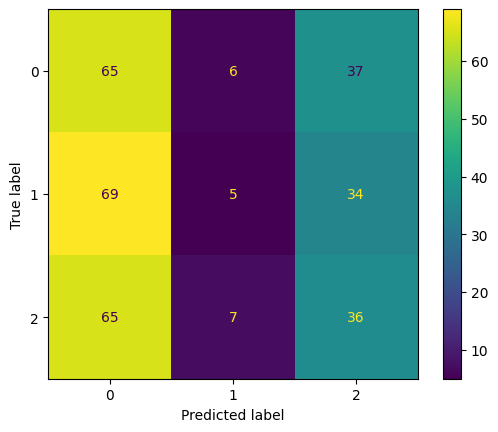

In [202]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(llama_3_2_3B_ground_truths, llama_3_2_3B_sentiment_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show()

## Llama 3.2 3B: Few-Shot In-Context Learning

In [203]:
import numpy as np

# hold the ground_truths
llama_3_2_3B_ground_truths = []
# hold the sentiment_predictions
llama_3_2_3B_sentiment_preds = []

# iterate through the validation set
for tweet, label in zip(ds_validation['text'], ds_validation['label']):
    prompt_tweet = tweet
    gt_label = label
    # combine the prompt
    prompt = generate_few_shot_prompt(prompt_tweet)
    
    # generate the response
    prompt_ids = llama_3_2_3B_tokenizer.encode(prompt, return_tensors="pt")

    outputs = llama_3_2_3B_model.generate(
                        prompt_ids,
                        temperature=0.08,
                        do_sample=True,
                        pad_token_id=llama_3_2_3B_tokenizer.eos_token_id,
                        max_new_tokens=1
                    )
    
    # get the response tokens from the model
    generated_tokens = outputs[-1]
    
    generated_response = llama_3_2_3B_tokenizer.decode(generated_tokens, skip_special_tokens=True)

    # pass the generated_response to a sanitizer that determines if the response is valid
    sentiment_resp = santize_response(generated_response[-1])
    
    # Responses being compared to the Ground_Truth Labels
    # print(f"Generated Response: {sentiment_resp}")
    # print(f"Ground Truth: {gt_label}")

    llama_3_2_3B_ground_truths.append(gt_label)
    llama_3_2_3B_sentiment_preds.append(sentiment_resp)

llama_3_2_3B_ground_truths = np.asarray(llama_3_2_3B_ground_truths)
llama_3_2_3B_sentiment_preds = np.asarray(llama_3_2_3B_sentiment_preds)


In [206]:
from sklearn.metrics import classification_report

few_shot_prompting_llama_32_3b_results = classification_report(llama_3_2_3B_ground_truths, llama_3_2_3B_sentiment_preds, output_dict=True)
print(classification_report(llama_3_2_3B_ground_truths, llama_3_2_3B_sentiment_preds))

              precision    recall  f1-score   support

           0       0.85      0.10      0.18       108
           1       0.36      0.87      0.51       108
           2       0.53      0.24      0.33       108

    accuracy                           0.40       324
   macro avg       0.58      0.40      0.34       324
weighted avg       0.58      0.40      0.34       324



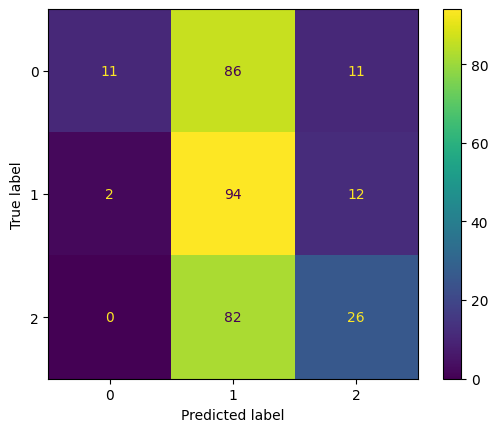

In [207]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(llama_3_2_3B_ground_truths, llama_3_2_3B_sentiment_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show()

## Phi 3.5-mini-instruct: Few Shot In-Context Learning

In [208]:
import numpy as np

# hold the ground_truths
phi_3_5_ground_truths = []
# hold the sentiment_predictions
phi_3_5_sentiment_preds = []

# iterate through the validation set
for tweet, label in zip(ds_validation['text'], ds_validation['label']):
    prompt_tweet = tweet
    gt_label = label
    # combine the prompt
    prompt = generate_few_shot_prompt(prompt_tweet)
    
    # generate the response
    prompt_ids = phi_3_5_tokenizer.encode(prompt, return_tensors="pt")

    outputs = phi_3_5_model.generate(
                        prompt_ids,
                        temperature=0.07,
                        do_sample=True,
                        pad_token_id=phi_3_5_tokenizer.eos_token_id,
                        max_new_tokens=1
                    )
    
    # get the response tokens from the model
    generated_tokens = outputs[-1]
    
    generated_response = phi_3_5_tokenizer.decode(generated_tokens, skip_special_tokens=True)

    # pass the generated_response to a sanitizer that determines if the response is valid
    sentiment_resp = santize_response(generated_response[-1])
    
    # Responses being compared to the Ground_Truth Labels
    # print(f"Generated Response: {sentiment_resp}")
    # print(f"Ground Truth: {gt_label}")

    phi_3_5_ground_truths.append(gt_label)
    phi_3_5_sentiment_preds.append(sentiment_resp)

phi_3_5_ground_truths = np.asarray(phi_3_5_ground_truths)
phi_3_5_sentiment_preds = np.asarray(phi_3_5_sentiment_preds)


In [209]:
from sklearn.metrics import classification_report

few_shot_prompt_phi_35_mini_results = classification_report(phi_3_5_ground_truths, phi_3_5_sentiment_preds, output_dict=True)
print(classification_report(phi_3_5_ground_truths, phi_3_5_sentiment_preds))

              precision    recall  f1-score   support

           0       1.00      0.03      0.05       108
           1       0.31      0.39      0.34       108
           2       0.51      0.88      0.65       108

    accuracy                           0.43       324
   macro avg       0.61      0.43      0.35       324
weighted avg       0.61      0.43      0.35       324



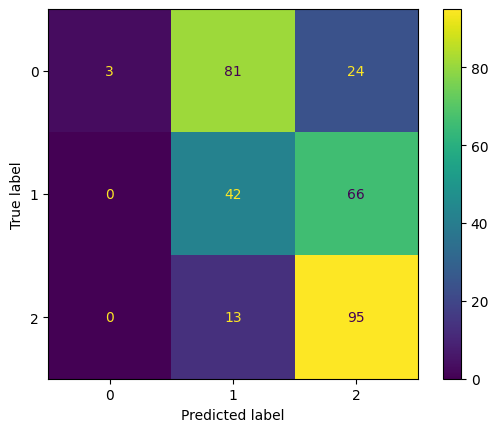

In [210]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(phi_3_5_ground_truths, phi_3_5_sentiment_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show()

## Experiment 2: Few-Shot In-Context Learning Results

### Few-Shot In-Context Model Precision Scores

Text(0.5, 1.0, 'Few-Shot In-Context Model Precision Scores')

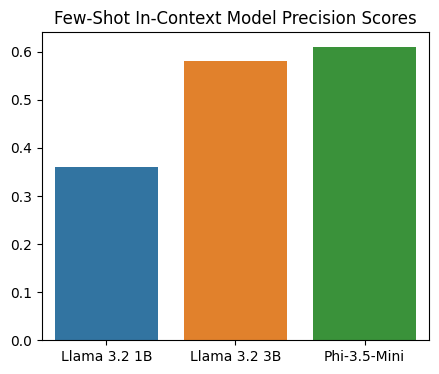

In [286]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.color_palette("Set2")

models = ['Llama 3.2 1B','Llama 3.2 3B','Phi-3.5-Mini']

few_shot_llama_32_1b = round(few_shot_in_context_llama_32_1b_results['macro avg']['precision'],2)

few_shot_llama_32_3b = round(few_shot_prompting_llama_32_3b_results['macro avg']['precision'],2)

few_shot_phi_3_5_mini = round(few_shot_prompt_phi_35_mini_results['macro avg']['precision'], 2)

# create precision plot list
precision_scores = [few_shot_llama_32_1b, few_shot_llama_32_3b, few_shot_phi_3_5_mini]

plt.figure(figsize=(5,4), dpi=100)
sns.barplot(x=models, y=precision_scores, hue=models)
plt.title('Few-Shot In-Context Model Precision Scores')

### Few-Shot In-Context Model Recall Scores

Text(0.5, 1.0, 'Few-Shot In-Context Model Recall Scores')

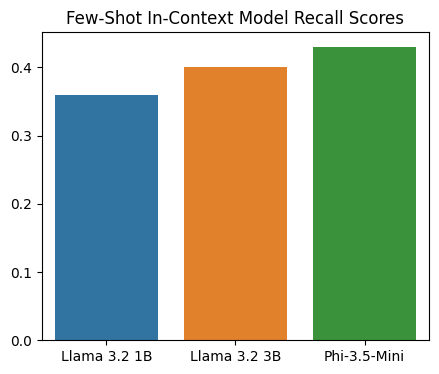

In [287]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.color_palette("Set2")

models = ['Llama 3.2 1B','Llama 3.2 3B','Phi-3.5-Mini']

few_shot_llama_32_1b = round(few_shot_in_context_llama_32_1b_results['macro avg']['recall'],2)

few_shot_llama_32_3b = round(few_shot_prompting_llama_32_3b_results['macro avg']['recall'],2)

few_shot_phi_3_5_mini = round(few_shot_prompt_phi_35_mini_results['macro avg']['recall'], 2)

# create precision plot list
recall_scores = [few_shot_llama_32_1b, few_shot_llama_32_3b, few_shot_phi_3_5_mini]

plt.figure(figsize=(5,4), dpi=100)
sns.barplot(x=models, y=recall_scores, hue=models)
plt.title('Few-Shot In-Context Model Recall Scores')

### Few-Shot In-Context Model F1-Scores

Text(0.5, 1.0, 'Few-Shot In-Context Model F1 Scores')

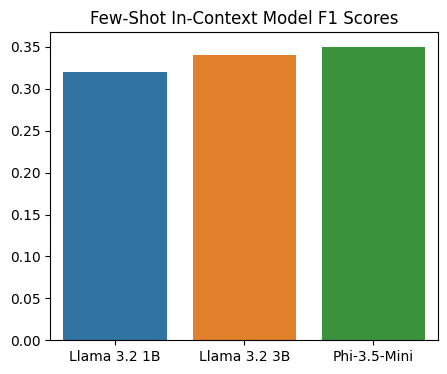

In [302]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.color_palette("Set2")

models = ['Llama 3.2 1B','Llama 3.2 3B','Phi-3.5-Mini']

few_shot_llama_32_1b = round(few_shot_in_context_llama_32_1b_results['macro avg']['f1-score'],2)

few_shot_llama_32_3b = round(few_shot_prompting_llama_32_3b_results['macro avg']['f1-score'],2)

few_shot_phi_3_5_mini = round(few_shot_prompt_phi_35_mini_results['macro avg']['f1-score'], 2)

# create precision plot list
f1_scores = [few_shot_llama_32_1b, few_shot_llama_32_3b, few_shot_phi_3_5_mini]

plt.figure(figsize=(5,4), dpi=100)
sns.barplot(x=models, y=f1_scores, hue=models)
plt.title('Few-Shot In-Context Model F1 Scores')

## Experiment 3: Advanced Prompting Technique (Zero-Shot Inference)

### Llama 3.2 1 B: Advanced Prompting Technique 

In [240]:
chain_of_thought_prompt = """
Read the following tweet:

{}

think about the sentiment, I need this for my homework,
respond with a single number that is your numeric choice of either (positive (2), negative (0), neutral (1)):  """

In [262]:
import numpy as np

# hold the ground_truths
llama_3_2_1B_ground_truths = []
# hold the sentiment_prediction
llama_3_2_1B_sentiment_preds = []

# iterate through the validation set
for tweet, label in zip(ds_validation['text'], ds_validation['label']):
    prompt_tweet = tweet
    gt_label = label
    # combine the prompt
    prompt = chain_of_thought_prompt.format(prompt_tweet)
    
    # generate the response
    prompt_ids = llama_3_2_1B_tokenizer.encode(prompt, return_tensors="pt")

    outputs = llama_3_2_1B_model.generate(
                        prompt_ids,
                        do_sample=True,
                        temperature=0.23,
                        pad_token_id=llama_3_2_1B_tokenizer.eos_token_id,
                        max_new_tokens=5
                    )
    
    # get the response tokens from the model
    generated_tokens = outputs[-1]
    
    generated_response = llama_3_2_1B_tokenizer.decode(generated_tokens, skip_special_tokens=True)

    # pass the generated_response to a sanitizer that determines if the response is valid
    # print(generated_response)
    
    # print(generated_response[-1])
    sentiment_resp = santize_response(generated_response[-1])
    
    # Responses being compared to the Ground_Truth Labels
    # print(f"Generated Response: {sentiment_resp}")
    # print(f"Ground Truth: {gt_label}")

    llama_3_2_1B_ground_truths.append(gt_label)
    llama_3_2_1B_sentiment_preds.append(sentiment_resp)

llama_3_2_1B_ground_truths = np.asarray(llama_3_2_1B_ground_truths)
llama_3_2_1B_sentiment_preds = np.asarray(llama_3_2_1B_sentiment_preds)


In [264]:
from sklearn.metrics import classification_report

adv_prompting_llama_3_2_1B_results = classification_report(llama_3_2_1B_ground_truths, llama_3_2_1B_sentiment_preds, output_dict=True)
print(classification_report(llama_3_2_1B_ground_truths, llama_3_2_1B_sentiment_preds))

              precision    recall  f1-score   support

           0       0.34      0.56      0.43       108
           1       0.19      0.05      0.07       108
           2       0.39      0.43      0.41       108

    accuracy                           0.35       324
   macro avg       0.30      0.35      0.30       324
weighted avg       0.30      0.35      0.30       324



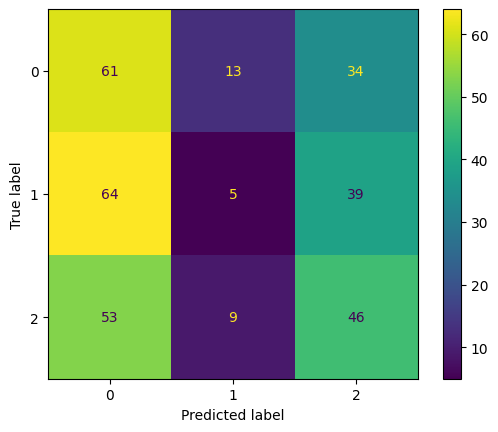

In [265]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(llama_3_2_1B_ground_truths, llama_3_2_1B_sentiment_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

## Llama 3.2 3B: Advanced Prompting Technique 

In [266]:
chain_of_thought_prompt = """
Read the following tweet:

{}

think about the sentiment, I need this for my homework,
respond with a single number that is your numeric choice of either (positive (2), negative (0), neutral (1)):  """

In [267]:
import numpy as np

# hold the ground_truths
llama_3_2_3B_ground_truths = []
# hold the sentiment_prediction
llama_3_2_3B_sentiment_preds = []

# iterate through the validation set
for tweet, label in zip(ds_validation['text'], ds_validation['label']):
    prompt_tweet = tweet
    gt_label = label
    # combine the prompt
    prompt = chain_of_thought_prompt.format(prompt_tweet)
    
    # generate the response
    prompt_ids = llama_3_2_3B_tokenizer.encode(prompt, return_tensors="pt")

    outputs = llama_3_2_1B_model.generate(
                        prompt_ids,
                        do_sample=True,
                        temperature=0.23,
                        pad_token_id=llama_3_2_3B_tokenizer.eos_token_id,
                        max_new_tokens=5
                    )
    
    # get the response tokens from the model
    generated_tokens = outputs[-1]
    
    generated_response = llama_3_2_1B_tokenizer.decode(generated_tokens, skip_special_tokens=True)

    # pass the generated_response to a sanitizer that determines if the response is valid
    # print(generated_response)
    
    # print(generated_response[-1])
    sentiment_resp = santize_response(generated_response[-1])
    
    # Responses being compared to the Ground_Truth Labels
    # print(f"Generated Response: {sentiment_resp}")
    # print(f"Ground Truth: {gt_label}")

    llama_3_2_3B_ground_truths.append(gt_label)
    llama_3_2_3B_sentiment_preds.append(sentiment_resp)

llama_3_2_3B_ground_truths = np.asarray(llama_3_2_3B_ground_truths)
llama_3_2_3B_sentiment_preds = np.asarray(llama_3_2_3B_sentiment_preds)


In [268]:
from sklearn.metrics import classification_report

adv_prompting_lllama_3_2_3B_results = classification_report(llama_3_2_3B_ground_truths, llama_3_2_3B_sentiment_preds, output_dict=True)
print(classification_report(llama_3_2_3B_ground_truths, llama_3_2_3B_sentiment_preds))

              precision    recall  f1-score   support

           0       0.38      0.64      0.48       108
           1       0.43      0.12      0.19       108
           2       0.38      0.40      0.39       108

    accuracy                           0.39       324
   macro avg       0.40      0.39      0.35       324
weighted avg       0.40      0.39      0.35       324



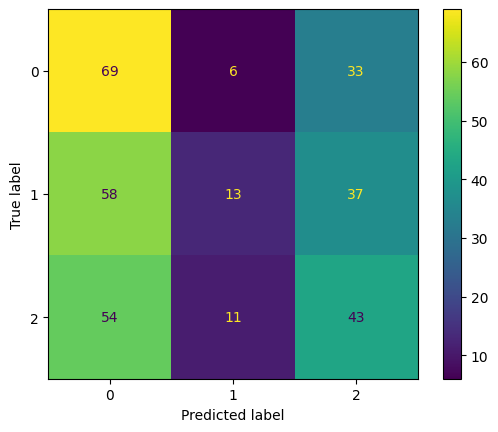

In [269]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(llama_3_2_3B_ground_truths, llama_3_2_3B_sentiment_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

## Phi 3.5-mini-instruct

In [270]:
chain_of_thought_prompt = """
Read the following tweet:

{}

think about the sentiment, I need this for my homework,
respond with a single number that is your numeric choice of either (positive (2), negative (0), neutral (1)):  """

In [274]:
import numpy as np

# hold the ground_truths
phi_3_5_ground_truths = []
# hold the sentiment_predictions
phi_3_5_sentiment_preds = []

# iterate through the validation set
for tweet, label in zip(ds_validation['text'], ds_validation['label']):
    prompt_tweet = tweet
    gt_label = label
    # combine the prompt
    prompt = generate_few_shot_prompt(prompt_tweet)
    
    # generate the response
    prompt_ids = phi_3_5_tokenizer.encode(prompt, return_tensors="pt")

    outputs = phi_3_5_model.generate(
                        prompt_ids,
                        temperature=0.1,
                        do_sample=True,
                        pad_token_id=phi_3_5_tokenizer.eos_token_id,
                        max_new_tokens=1
                    )
    
    # get the response tokens from the model
    generated_tokens = outputs[-1]
    
    generated_response = phi_3_5_tokenizer.decode(generated_tokens, skip_special_tokens=True)

    # pass the generated_response to a sanitizer that determines if the response is valid
    sentiment_resp = santize_response(generated_response[-1])
    
    # Responses being compared to the Ground_Truth Labels
    # print(f"Generated Response: {sentiment_resp}")
    # print(f"Ground Truth: {gt_label}")

    phi_3_5_ground_truths.append(gt_label)
    phi_3_5_sentiment_preds.append(sentiment_resp)

phi_3_5_ground_truths = np.asarray(phi_3_5_ground_truths)
phi_3_5_sentiment_preds = np.asarray(phi_3_5_sentiment_preds)


In [275]:
from sklearn.metrics import classification_report

adv_prompt_phi_35_mini_results = classification_report(phi_3_5_ground_truths, phi_3_5_sentiment_preds, output_dict=True)
print(classification_report(phi_3_5_ground_truths, phi_3_5_sentiment_preds))

              precision    recall  f1-score   support

           0       0.67      0.02      0.04       108
           1       0.30      0.36      0.33       108
           2       0.50      0.89      0.64       108

    accuracy                           0.42       324
   macro avg       0.49      0.42      0.34       324
weighted avg       0.49      0.42      0.34       324



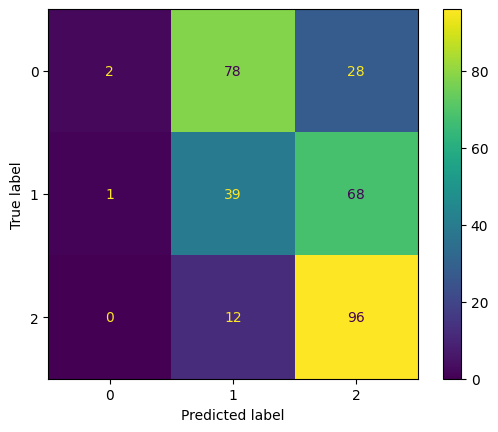

In [276]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(phi_3_5_ground_truths, phi_3_5_sentiment_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show()

## Experiment 3: Advanced Prompting Technique (Zero-Shot Innference) Results

### Advanced Prompting Technique Model Precision Scores

Text(0.5, 1.0, 'Advanced Prompting Technique Model Precision Scores')

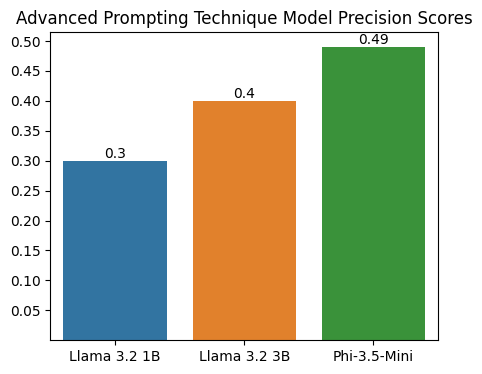

In [367]:
import numpy as np  
import matplotlib.pyplot as plt 
import seaborn as sns

sns.color_palette("Set2")
  
models = ['Llama 3.2 1B','Llama 3.2 3B','Phi-3.5-Mini'] 

adv_prompting_llama_32_1b = round(adv_prompting_llama_3_2_1B_results['macro avg']['precision'], 2)

adv_prompting_llama_32_3b = round(adv_prompting_lllama_3_2_3B_results['macro avg']['precision'], 2)

adv_prompting_phi_35_mini = round(adv_prompt_phi_35_mini_results['macro avg']['precision'], 2)

precision_scores = [adv_prompting_llama_32_1b, adv_prompting_llama_32_3b, adv_prompting_phi_35_mini]

plt.figure(figsize=(5,4), dpi=100)
ticks = np.arange(0.05,0.65,0.05) 

plt.yticks(ticks=ticks)
ax = sns.barplot(x=models, y=precision_scores, hue=models )
# add labels
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
ax.bar_label(ax.containers[2], fontsize=10)
plt.title('Advanced Prompting Technique Model Precision Scores')

### Advanced Prompting Technique Model Recall Scores

Text(0.5, 1.0, 'Advanced Prompting Technique Model Recall Scores')

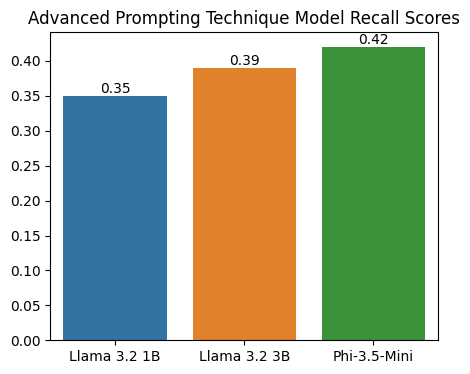

In [378]:
import numpy as np  
import matplotlib.pyplot as plt 
import seaborn as sns

sns.color_palette("Set2")
  
models = ['Llama 3.2 1B','Llama 3.2 3B','Phi-3.5-Mini'] 

adv_prompting_llama_32_1b = round(adv_prompting_llama_3_2_1B_results['macro avg']['recall'], 2)

adv_prompting_llama_32_3b = round(adv_prompting_lllama_3_2_3B_results['macro avg']['recall'], 2)

adv_prompting_phi_35_mini = round(adv_prompt_phi_35_mini_results['macro avg']['recall'], 2)

recall_scores = [adv_prompting_llama_32_1b, adv_prompting_llama_32_3b, adv_prompting_phi_35_mini]

plt.figure(figsize=(5,4), dpi=100)


ax = sns.barplot(x=models, y=recall_scores, hue=models )

# add labels
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
ax.bar_label(ax.containers[2], fontsize=10)

plt.title('Advanced Prompting Technique Model Recall Scores')

### Advanced Prompting Technique Model F2 Scores

Text(0.5, 1.0, 'Advanced Prompting Technique Model F1-Score Results')

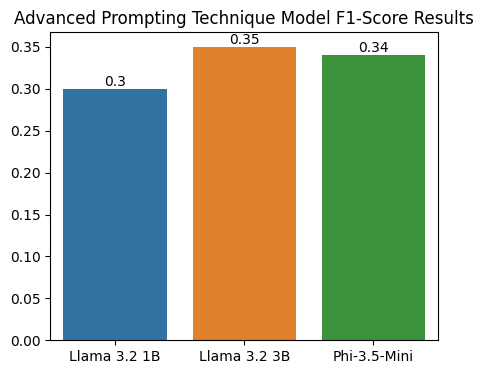

In [377]:
import numpy as np  
import matplotlib.pyplot as plt 
import seaborn as sns

sns.color_palette("Set2")
  
models = ['Llama 3.2 1B','Llama 3.2 3B','Phi-3.5-Mini'] 

adv_prompting_llama_32_1b = round(adv_prompting_llama_3_2_1B_results['macro avg']['f1-score'], 2)

adv_prompting_llama_32_3b = round(adv_prompting_lllama_3_2_3B_results['macro avg']['f1-score'], 2)

adv_prompting_phi_35_mini = round(adv_prompt_phi_35_mini_results['macro avg']['f1-score'], 2)

f1_scores = [adv_prompting_llama_32_1b, adv_prompting_llama_32_3b, adv_prompting_phi_35_mini]

plt.figure(figsize=(5,4), dpi=100)

ax = sns.barplot(x=models, y=f1_scores, hue=models )
# add labels
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
ax.bar_label(ax.containers[2], fontsize=10)

plt.title('Advanced Prompting Technique Model F1-Score Results')

## Combined Results from Experiments

### Precision Scores of Models Per Experiment

In [384]:
import pandas as pd


# experiment 1 precision results
exp_1_llama_32_1b_precision = round(zero_shot_llama_3_2_1B_model_results['macro avg']['precision'], 2)

exp_1_llama_32_3b_precision = round(zero_shot_llama_3_2_3B_results['macro avg']['precision'], 2)

exp_1_phi_35_mini_precision = round(zero_shot_phi_3_5_results['macro avg']['precision'], 2)

# experiment 2 precision results
exp_2_llama_32_1b_precision = round(few_shot_in_context_llama_32_1b_results['macro avg']['precision'], 2)

exp_2_llama_32_3b_precision = round(few_shot_prompting_llama_32_3b_results['macro avg']['precision'], 2)

exp_2_phi_35_mini_precision = round(few_shot_prompt_phi_35_mini_results['macro avg']['precision'], 2)

# experiment 3 precision results
exp_3_llama_32_1b_precision = round(adv_prompting_llama_3_2_1B_results['macro avg']['precision'], 2)

exp_3_llama_32_3b_precision = round(adv_prompting_lllama_3_2_3B_results['macro avg']['precision'], 2)

exp_3_phi_35_mini_precision = round(adv_prompt_phi_35_mini_results['macro avg']['precision'], 2)


precision_data = {'Experiment': ['Zero-Shot Experiment 1','Few-Shot Experiement 2','Advanced Prompting Technique Experiment 3'],
                  'Model': [
                          ['Llama 3.2 1B', 'Llama 3.2 3B', 'Phi-3.5-Mini'],
                          ['Llama 3.2 1B', 'Llama 3.2 3B', 'Phi-3.5-Mini'],
                          ['Llama 3.2 1B', 'Llama 3.2 3B', 'Phi-3.5-Mini']
                  ],
                  'Precision': [
                                [exp_1_llama_32_1b_precision, exp_1_llama_32_3b_precision, exp_1_phi_35_mini_precision],
                                [exp_2_llama_32_1b_precision, exp_2_llama_32_3b_precision, exp_2_phi_35_mini_precision],
                                [exp_3_llama_32_1b_precision, exp_3_llama_32_3b_precision, exp_3_phi_35_mini_precision]
                               ]
                }

df_precision = pd.DataFrame(data=precision_data)

# expands each model and precision value to a new row per experiment 
df_precision = df_precision.explode(['Model', 'Precision'], ignore_index=True)

# dataframe to represent the model's and their precision scores
df_precision


,Experiment,Model,Precision
0,Zero-Shot Experiment 1,Llama 3.2 1B,0.35
1,Zero-Shot Experiment 1,Llama 3.2 3B,0.31
2,Zero-Shot Experiment 1,Phi-3.5-Mini,0.6
3,Few-Shot Experiement 2,Llama 3.2 1B,0.36
4,Few-Shot Experiement 2,Llama 3.2 3B,0.58
5,Few-Shot Experiement 2,Phi-3.5-Mini,0.61
6,Advanced Prompting Technique Experiment 3,Llama 3.2 1B,0.3
7,Advanced Prompting Technique Experiment 3,Llama 3.2 3B,0.4
8,Advanced Prompting Technique Experiment 3,Phi-3.5-Mini,0.49


### Precision of Models Over All Experiments

Text(0.5, 1.0, 'Model Precision Scores Per Experiment')

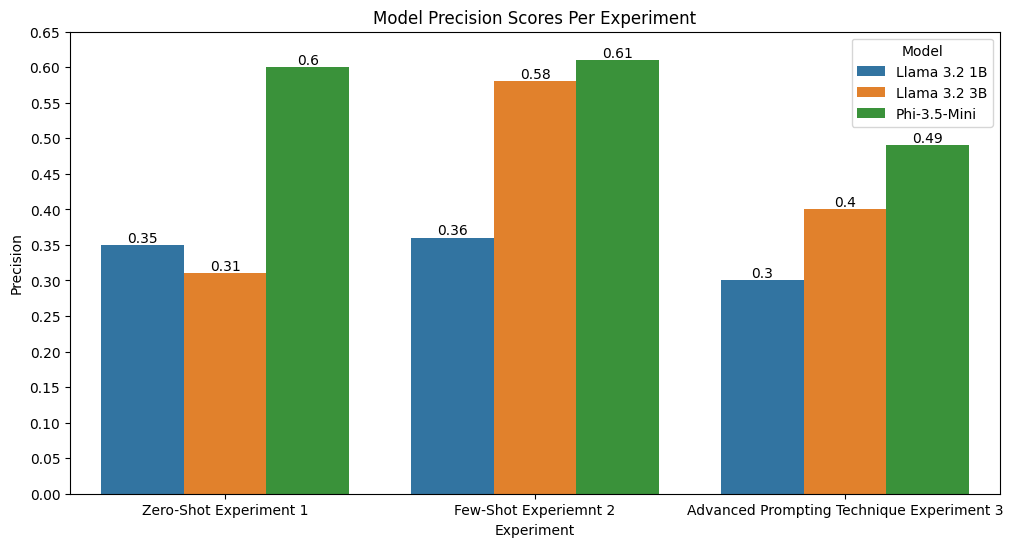

In [383]:
import numpy as np  
import matplotlib.pyplot as plt 
import seaborn as sns

plt.figure(figsize=(12,6), dpi=100)
y_range = np.arange(0.0,0.7,0.05)


ax = sns.barplot(data=df_precision, x=df_precision['Experiment'], y=df_precision['Precision'], hue=df_precision['Model'])
ax.bar_label(ax.containers[0], fontsize=10);
ax.bar_label(ax.containers[1], fontsize=10);
plt.yticks(ticks=y_range) 
ax.bar_label(ax.containers[2], fontsize=10);
plt.title('Model Precision Scores Per Experiment')